# Test

6/13/2018

This document is used to test the whole code to clean user configuration csv.


# 0 Preparation

## 0.1 Import packages

In [1]:
#import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
#set width of column
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 999
#suppress warning
import warnings
warnings.filterwarnings("ignore")
#translation api
from googletrans import Translator
import math

## 0.2 Load Dataset

In [152]:
#Read CSV
#test using 20_24
file = '2017_12_13_15_20.csv'
user= pd.read_csv(file).sample(200)
## drop unuseful columns
user=user.drop(['device_type','product_name','event_id','device_id','device_hw_form'],axis=1)
## drop row whose info is almost lost
user=user[user['device_hw_ram'].notnull()]
user.head()

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version
458637,AMD Ryzen 5 1600 Six-Core Processor,16GB,1920x1080,AMD Radeon R7 240,Microsoft Windows 10 Pro,10.0.15063 Build 15063
234732,Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz,8GB,1920x1080,Intel(R) HD Graphics 620,Microsoft Windows 10 Pro,10.0.15063 Build 15063
165194,Intel(R) Core(TM) i7-4770 CPU @ 3.40GHz,16GB,1280x1024,NVIDIA GeForce GTX 645,Microsoft Windows 7 Professional,6.1.7601 Service Pack 1 Build 7601
439039,Intel(R) Core(TM) i7-3770 CPU @ 3.40GHz,32GB,1920x1080,AMD FirePro 2270,Microsoft Windows 7 Enterprise,6.1.7601 Service Pack 1 Build 7601
436199,Intel64 Family 6 Model 58 Stepping 9 Intel(R) Core(TM) i5-3570 CPU @ 3.40GHz,8GB 2214592512,"1920x1080 96,96 32","Intel(R) HD Graphics, PCI\VEN_8086&DEV_0152&SUBSYS_052C1028&REV_09\3&11583659&0&10",Microsoft Windows 10 Enterprise,10.0.14393 Build 14393


In [58]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839525 entries, 0 to 839582
Data columns (total 6 columns):
device_hw_proc       839525 non-null object
device_hw_ram        839525 non-null object
device_hw_display    823690 non-null object
device_hw_video      823690 non-null object
device_os_name       839525 non-null object
device_os_version    839525 non-null object
dtypes: object(6)
memory usage: 44.8+ MB


## 0.3 Run Basic Function

In [5]:
def drawratio(df):
    value_count=df.value_counts()
    value_ratio=round(100*df.value_counts()/len(df),3)
    return pd.concat([value_count.rename('Count'), value_ratio.rename('Ratio %')], axis=1)

# 1 CPU

In [153]:
def deleteStepping(s,brand,stepping):
    length=len(stepping)-1
    
    start = s[s.find(brand)+length:].find(brand)+length
    
    return s[start:]

def splitC(s):
    ##make data consistent#
    s=" ".join(s.split())
    
    if 'Pentium(R)' in s and 'Intel(R) Pentium(R)' not in s:
        s= s.replace('Pentium(R)','Intel(R) Pentium(R)')
    elif 'Celeron(R)' in s and 'Intel(R) Celeron(R)' not in s:
        s= s.replace('Celeron(R)','Intel(R) Celeron(R)')
    elif 'Intel(R)' in s and 'Core(TM)' not in s and 'Core' in s and '-Core' not in s:
        s= s.replace('Core','Core(TM)')
    elif 'AMD64' in s and 'Quad-Core' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    elif 'Quad-Core' in s and 'Processor' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    else:
        s=s

        
    if 'AMD' in s and 'RADEON' in s:
        s= s.replace('RADEON','Radeon') 
    if 'AMD' in s and " APU with AMD " in s:
        s=s.replace(" with AMD "," ")
    if 'AMD' in s and " APU " in s:
        s=s.replace(" APU "," ")
    if 'AMD' in s and " with " in s:
        s=s.replace(" with "," ")
    if 'AMD' in s and " Graphics" in s:
        s=s.replace("Graphics","")
    if 'AMD' in s and "Radeon(TM)" in s:
        s=s.replace("Radeon(TM)","Radeon")
    if "Radeon(tm)" in s:
        s=s.replace("Radeon(tm)","Radeon")
    
    if 'i3 ' in s and 'i3-' not in s:
        s=s.replace('i3 ','i3-')
    elif 'i5 ' in s and 'i5-' not in s:
        s=s.replace('i5 ','i5-')
    elif 'i7 ' in s and 'i7-' not in s:
        s=s.replace('i7 ','i7-')
    else:
        s=s
        
    ###extract with comma
    if ',' in s:
        first=s.split(',')[0]
        second=s.split(',')[1].lstrip()
        if 'Intel64' in first and 'Intel64' in second:
            firstN = deleteStepping(first,'Intel','Intel64')
            secondN=deleteStepping(second,'Intel','Intel64')
            return (firstN,secondN)      
        elif 'Intel' in first and 'Intel' in second:
            start1 = first.find('Intel')
            start2 = second.find('Intel')
            return (first[start1:],second[start2:])
        elif 'AMD' in first  and ('CORES' in second.upper() or '+' in second):
            if 'AMD64' in first:
                return deleteStepping(first,'AMD','AMD64')
            else:
                start = first.find('AMD')
                s= first[start:]
                return s
        elif 'AMD64' in first and 'AMD64' in second:
            firstN = deleteStepping(first,'AMD','AMD64')
            secondN = deleteStepping(second,'AMD','AMD64')
            return (firstN,secondN)
        elif 'AMD' in second and 'AMD' in first:
            start1 = first.find('AMD')
            start2 = second.find('AMD')
            return (first[start1:],second[start2:])
        elif 'AMD' not in s and 'Intel' not in s:
            return 'Unusual'
        else:
            return 'Unusual'
    else:
        if 'Intel' in s and 'Intel64' in s:
            start = s[s.find('Intel64')+6:].find('Intel')+6
        elif 'Intel' in s and 'Genuine' in s:
            start = s.find('Genuine')
        elif 'Intel' in s:
            start = s.find('Intel')       
                    
        elif 'AMD64' in s:
            if 'AMD ' in s:
                start =s[s.find('AMD64')+4:].find('AMD')+4
            else:
                start=s.find('AMD64')
        elif ('x64' in s  or 'x86' in s) and 'AMD' in s:
            start =s.find('AMD')
        else:
            start=0
            
    s=" ".join(s.split())
       
    return s[start:]

def splitB(s):
    if len(s)!=2:
        if 'Intel' in s:
            if 'CPU' in s:
                s=s.replace('CPU',' ')
            if '@' in s:
                end = s.find('@')
            elif '-' in s:
                end = s.find('-')+5
            else:
                end=len(s)+1

            if 'Genuine' in s:
                start = s.find('Genuine')
            elif 'Intel(R)' in s:
                start = s.find('Intel(R)')+8
            else:
                start=0
            sn=s[start:end]
        else:
            sn=s
    else:
        return s
    
    ##correct Core(TM)2 E series
    if 'Core(TM)2' in s and 'Core(TM)2 Duo' not in s and 'Quad' not in s:
        sn=sn.replace('Core(TM)2','Core(TM)2 Duo')
    elif 'Core(TM) Duo' in s and 'Core(TM)2 Duo' not in s:
        sn=sn.replace('Core(TM) Duo','Core(TM)2 Duo')
    else:
        sn=sn
    sn=" ".join(sn.split()) 
    ###correct E series
    series = [' 4300',' 4400',' 6300',' 6320',' 6400',' 6420',' 6600',' 6700']


    if 'Core(TM)2 Duo'in sn:
        for sery in series:
            if 'Core(TM)2 Duo'+sery in sn:
                sn=sn.replace(sery,' E'+sery.lstrip())
                break
    return sn    
    
user['Name']=user.device_hw_proc.apply(splitC)
#user['CPU#']=user['Name'].apply(lambda x: 2 if len(x)==2 else 1)

user['brand']=user.Name.apply(splitB)
user.drop('Name',axis=1,inplace=True)

In [81]:
pd.DataFrame(user.brand.value_counts())

,brand
Core(TM) i7-6700,34639
Core(TM) i7-6700HQ,26451
Core(TM) i7-4790,22643
Core(TM) i7-7700HQ,20145
Core(TM) i5-7200U,19949
Core(TM) i7-7700,19763
Core(TM) i7-7500U,18883
Core(TM) i5-6200U,18378
Core(TM) i7-6500U,16747
Core(TM) i5-6500,16483


In [114]:
user[user.brand=='Unusual']

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version,brand


In [155]:
def getL(df,threshold):
    df=(100*df.brand.value_counts()/len(df.brand)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterC(s,listC):
    if s in listC:
        return s
    else:
        return 'Rare'
    
listC = getL(user,0.24)

user['brand']=user['brand'].apply(lambda x:filterR(x,listC))

In [154]:
dd=(100*user.brand.value_counts()/len(user.brand)).sort_values()
dd[dd.cumsum()>0.24].index

Index(['AMD Ryzen 5 1600 Six-Core Processor',
                         'Core(TM) i5-3337U',
                          'Pentium(R) G2030',
                       'Xeon(R) E3-1505M v5',
                         'Core(TM) i5-4200M',
                          'Core(TM) i7- 870',
                    'AMD A6-5350M Radeon HD',
                          'Core(TM) i3-6100',
                          'Core(TM) i3-2120',
                        'Core(TM) i5- M 460',
       ...
                          'Core(TM) i7-7700',
                          'Core(TM) i7-3770',
                         'Core(TM) i5-6200U',
                          'Core(TM) i7-4770',
                        'Core(TM) i7-7700HQ',
                         'Core(TM) i7-7500U',
                          'Core(TM) i7-6700',
                          'Core(TM) i7-4790',
                         'Core(TM) i5-7200U',
                        'Core(TM) i7-6700HQ'],
      dtype='object', length=113)

In [156]:
user.brand.value_counts()

Core(TM) i7-6700HQ                                                                        11
Core(TM) i5-7200U                                                                         10
Core(TM) i7-4790                                                                           7
Core(TM) i7-6700                                                                           7
Core(TM) i7-7500U                                                                          7
Core(TM) i7-7700HQ                                                                         6
Core(TM) i7-4770                                                                           6
Core(TM) i5-6200U                                                                          5
Core(TM) i7-3770                                                                           5
Core(TM) i7-7700                                                                           5
Core(TM) i5-4210U                                                     

# 3 Graphic Card

In [131]:
def consis(s):
    if 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
    if 'Intel(R)' in s and 'Intel(R) -' in s:
        s=s.replace('Intel(R) -','Intel(R)')
    if 'Intel(R)' in s and 'Family ' in s:
        s=s.replace('Family ','Family')
    if 'Intel' in s and '(PE) ' in s:
        s=s.replace('(PE) ','')
    if 'Intel' in s and '(PE64) ' in s:
        s=s.replace('(PE64) ','')
    
    if 'Radeon(TM)' in s:
        s=s.replace('Radeon(TM)','Radeon')
    if 'Radeon (TM)' in s:
        s=s.replace('Radeon (TM)','Radeon')
    if 'RADEON' in s:
        s=s.replace('RADEON','Radeon')
    if 'Radeon.' in s:
        s=s.replace('Radeon.','Radeon')
    if 'RadeonT' in s:
        s=s.replace('RadeonT','Radeon')
    
    if 'Radeon' in s and 'AMD' not in s and 'ATI' not in s:
        s=s.replace('Radeon','AMD(ATI) Radeon')
    if 'ASUS' in s and 'Radeon' in s:
        s=s.replace('ASUS','')
    if 'Intel' in s and 'Iris' in s and 'Iris(TM)' not in s:
        s=s.replace('Iris','Iris(TM)')
    if 'Intel' in s and 'Iris(R)' in s:
        s=s.replce('Iris(R)','Iris(TM)')
    if 'ATI' in s and 'AMD' not in s:
        s=s.replace('ATI','AMD(ATI)')
    if 'AMD' in s and 'ATI' not in s:
        s=s.replace('AMD','AMD(ATI)')
    
    # delete redundant info
    if 'AMD' in s or 'Intel(R)' in s or 'NVIDIA' in s:
        if '(Microsoft Corporation - WDDM 1.0)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.0)','')
        elif '(Microsoft Corporation - WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.1)','') 
        elif '(Microsoft Corporation - WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation - WDDM v1.1)' in s:
            s=s.replace(' (Microsoft Corporation - WDDM v1.1)','')
        elif '(Microsoft Corporation WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation WDDM 1.1)','')
        elif '(Microsoft Corporation - WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.20)','')
        elif '(Microsoft Corporation - WDDM v1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.2)','')
        elif '(Engineering Sample - WDDM v1.1)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.1)','')
        elif '(Microsoft Corporation - WDDM)' in s:
            s=s.replace('(Microsoft Corporation - WDDM)','')
        elif '(Microsoft Corporation- WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation- WDDM v1.20)','')
        elif '(Bootcamp XG edition by bootcampdrivers.com)' in s:
            s=s.replace('(Bootcamp XG edition by bootcampdrivers.com)','')
        elif '(Engineering Sample - WDDM v1.20)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.20)','')
        else:
            s=s
    # Clean ASUS
    if 'ASUS' in s:
        if 'EAH' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('EAH', 'HD ').replace(' Series','') 
        elif 'HD' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('HD','HD ').replace(' Series','')
        elif 'R5' in s or 'R7' in s or 'R9' in s:
            s=s.replace('ASUS','AMD(ATI) Radeon ').replace(' Series','')
        else:
            s='UNKNOWN'
        s=" ".join(s.split())
    
    if 'AMD' in s and (' Series' in s or ' Graphics' in s or ' series' in s or ' graphics' in s or ' Graphic' in s):
        s=s.replace(' Series','')
        s=s.replace(' series','')
        s=s.replace(' Graphics','')
        s=s.replace(' graphics','')
        s=s.replace(' Graphic','')

        
    s=" ".join(s.split())
    return s                                                

        

def cleanGC(s):
    if isinstance(s, float)==True:
        return s
    
    s=consis(s)
    
    if ',' in s:
        names = s.split(',')
        new = []
        for name in names:
            if '\\' not in name and 'PCI' not in name and 'ROOT' not in name and '%' not in name:
                new.append(name)
        s= ",".join(new)
    elif s[0]=='@' or s[0]=='\\' or s.startswith('PCI'):
        s='UNKNOWN'
        
    
    if ';' in s:
        names = s.split(';')
        new = []
        for name in names:
            if '%' not in name and '@' not in name:
                new.append(name)
        s=";".join(new)
    if s=='' or s[0]=='@' or s[0]=='%':
        return 'UNKNOWN'
    return s

def lzytrans(s):
    if isinstance(s, float)==True:
        return s  
    if ('Microsoft' in s or 'Майкрософт' in s) and ('Adaptador' in s or '适配器' in s or 'видеоадаптер' in s or '기본 디스플레이 어댑터' in s or 'Vídeo Básico' in s or 
                               'Görüntü Bağdaştırıcısı' in s or '基本顯示卡' in s or 'vidéo' in s or 'ディスプレイ アダプター' in s or 
                              'Základní grafický adaptér' in s or 'Placa Gráfica Básica da' in s or 'Microsoftin perusnäyttösovitin' in s or
                            'Microsoft Basic-skærmkort' in s or 'Βασικός προσαρμογέας οθόνης Microsoft' in s or 'Базовый видеоадаптер' in s or
          'videokártya' in s or '기본 디스플레이 드라이버' in s or 'Podstawowa karta graficzna' in s or 'Scheda video' in s):
        s= 'Microsoft Basic Display Adapter'
    elif 'Hyper-V' in s or 'Video för Hyper-V från Microsoft' in s:
        s= 'Microsoft Hyper-V-Video'
    elif 'VGA' in s and 'VMware' not in s and 'Wifi' not in s:
        s='Standard VGA Graphics Adapter'
    elif 'Семейство наборов микросхем Intel(R) G33/G31 Express' in s or 'Intel(R) G33/G31 Express Yonga Kümesi Ailesi' in s\
          or 'Familia Intel(R) G33/G31 Express Chipset' in s:
        s='Intel(R) G33/G31 Express Chipset Family'
    elif 'Набор микросхем Intel(R) G41 Express' in s or 'Intel(R) Express Chipset G41' in s:
        s='Intel(R) G41 Express Chipset'
    elif 'Mikroukład Intel(R) Q45/Q43 Express Chipset' in s or 'Набор микросхем Intel(R) Q45/Q43 Express' in s\
          or 'Intel(R) Express Chipset Q45/Q43' in s:
        s='Intel(R) Q45/Q43 Express Chipset'
    elif 'Семейство наборов микросхем Mobile Intel(R) 45 Express' in s or 'Mobile Intel(R) 45 Express lapkakészletcsalád' in s\
          or 'Familia Mobile Intel(R) 45 Express Chipset' in s:
        s='Mobile Intel(R) 45 Express Chipset Family'

    elif 'Familia Intel(R) 82945G Express Chipset' in s:
        s='Intel(R) 82945G Express Chipset Family'
    elif 'Familia Mobile Intel(R) 965 Express Chipset' in s:
        s='Mobile Intel(R) 965 Express Chipset Family '
    elif 'Intel(R) - famiglia Express Chipset Q965/Q963' in s:
        s='Intel(R) Q965/Q963 Express Chipset'
    elif 'Familia' in s:
        s=s.replace('Familia','')+' Family'
    else:
        s=s
    
    """"
    # takes long time to run
    if isEnglish(s)==False:
        translator = Translator()
        t=translator.translate(s).text.title()
        s=t
    """
    if 'корпорация Майкрософт' in s:
        s=s.replace('корпорация Майкрософт','Microsoft Corporation')
    return s

def solveVM(s):
    if isinstance(s, float)==True:
        return s
    elif 'VGA' in s.upper():
        if 'VMware' in s:
            return 'VMware SVGA 3D'
        elif 'Standard' in s or 'Scheda' in s or 'Standardowa' in s or 'standard' in s:
            return 'Standard VGA Graphics Adapter'
        elif 'Wifi' in s:
            return 'Wireless'
        else:
            return s
    elif 'Microsoft' in s and ('Basic' in s or 'Base' in s):
        return 'Microsoft Basic Display Adapter'
    elif 'Microsoft' in s and 'Hyper' in s:
        return 'Microsoft Hyper-V Video'
    elif 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
        if 'Iris' in s and 'Iris(TM)' not in s:
            s=s.replace('Iris','Iris(TM)')
        elif 'Iris(R)' in s:
            s=s.replce('Iris(R)','Iris(TM)')
        if s.startswith('The'):
            s= s.replace('The','')
        return s
    elif 'Mirage' in s or 'Mirror' in s or 'BB Capture Driver' in s:
        return 'Mirror'
    elif 'Remote' in s or 'RC' in s:
        return 'Remote'
    elif 'DisplayLink USB' in s or 'Projector' in s:
        return 'Wireless'
    elif 'Parallels Display' in s or 'hook driver' in s or 'Citrix Display' in s or 'ShoreTel Desktop' in s\
          or 'VirtualBox Graphics' in s or 'Fujitsu Live Help graphics driver' in s or \
          'Freedom Scientific Accessibility' in s or 'ASPEED Graphics Family' in s:
        return 'Remote'
    else:
        s=s
    s=" ".join(s.split())
    return s

##### clean the duplicate GPU info
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def mergeGPU(row):
    s=row['GC']
    
    if isinstance(s, float)==True:
        return s
    
    if ',' in s and row['CPU#']==1:
        if s.count('Intel(R)')>=2:
            start=find_nth(s,'Intel',2)
            s=s[:start]
        elif s.count('NVIDIA')>=2:
            start=find_nth(s,'NVIDIA',2)
            s=s[:start]
        elif s.count('AMD')>=2:
            start=find_nth(s,'AMD',2)
            s=s[:start]
        else:
            return 'Duplicate GPU'
    elif ',' in s and row['CPU#']==2:
        return '2 GPUs'
    else:
        s=s
    s=" ".join(s.split())
    return s

def loadGC(s):
    #consistent and clean
    s=cleanGC(s)
    s=lzytrans(s)
    s=solveVM(s)
    return s


user['GC']=user.device_hw_video.apply(loadGC)
user['GC']=user.apply(mergeGPU,axis=1)

In [130]:
def typeGPU(s):
    if isinstance(s, float)==True:
        return 'UNKNOWN'
    
    if 'Intel' in s:
        return 'Intel'
    elif 'AMD' in s:
        return 'AMD'
    elif 'NVIDIA' in s:
        return 'NVIDIA'
    elif 'Microsoft Basic Display' in s:
        return s
    elif 'Microsoft Hyper-V Video' in s:
        return s
    elif 'Mirror' in s:
        return 'Mirror'
    elif 'Remote' in s:
        return 'Remote'
    elif 'VMware' in s:
        return s
    elif 'UNKNOWN' in s:
        return s
    elif 'Wireless' in s:
        return s
    elif 'Matrox' in s:
        return 'Matrox'
    elif 'Standard VGA' in s:
        return 'Standard VGA Graphics Adapter'
    elif 'Windows Live Display Driver' in s:
        return s
    else:
        return 'Others'
user.GC.apply(typeGPU).value_counts()
drawratio(user.GC.apply(typeGPU))
user[user.GC.apply(typeGPU)=='Others'].GC.value_counts()

Series([], Name: GC, dtype: int64)

In [127]:
#user.loc[user.GC.apply(typeGPU)=='Others','GC']='Rare'
user[user.GC.apply(typeGPU)=='Rare'].GC.value_counts().sum()

0

In [86]:
user.GC.str.split().str[0].value_counts()[:20]

Intel(R)     401997
NVIDIA       297653
AMD(ATI)      82620
Mirror        13073
Microsoft     12450
VMware         4529
UNKNOWN        3225
Remote         2207
Mobile         1691
Wireless       1575
AMD            1389
Standard        546
Matrox          165
Famille         116
CA               77
Jeu              72
Windows          47
Trigger          33
(PE64)           24
Glance           18
Name: GC, dtype: int64

# 4 RAM

In [116]:
def splitR(s):
    if s =='UNKNOWN':
        return np.nan
    elif 'GB' in s:
        return s[:s.find('GB')]
    else:
        return 'Others'
user['RAM'] = user['device_hw_ram'].apply(splitR)
    
def getL(df,threshold):
    df=(100*df.RAM.value_counts().sort_index()/len(df.RAM)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterR(s,listR):
    if s in listR:
        return s
    else:
        return 'Rare'
    
listR = getL(user,0.24)

#user['RAM']=user['RAM'].apply(lambda x:filterR(x,listR))


In [100]:
user.RAM.value_counts()

8       316572
16      208456
4       137807
32       51058
12       27218
3        25101
6        24661
7        10921
2         9780
24        6773
64        5393
15        3301
20        2016
Rare      1973
5         1926
10        1496
11        1364
14         775
48         619
31         583
1          507
40         436
18         413
128        376
Name: RAM, dtype: int64

# 5 OS

In [117]:
user['device_os_name'] = user['device_os_name'].apply(lambda x: " ".join(x.split()))

def findOS(s):
    
    """
    
        version = ['Windows 8','Windows 8.1','Windows 7','Windows 10','Windows Server 2012',
                   'Windows Server 2008','Windows Server 2016']
        
        vs=""
        
        for v in version:
            if v in s:
                vs=v
                break                             
        x=vs
   """
    if 'WINDOWS' in s.upper() or 'enterprise' in s or 'Microsoft' in s or 'Майкрософт' in s:
        
        x='Windows'
    
        if 'pro' in s.lower() or 'professional' in s.lower() or '专业' in s or '專業' in s or 'Профессиональная' in s or 'Altum' in s:
            return x+' Pro'
        elif 'Home' in s or '家庭' in s or '家用' in s or 'Famille' in s or 'Домашняя' in s or 'Familiale' in s:
            return x+' Home'
        elif '企业' in s or 'entreprise' in s.lower() or '企業' in s or 'Корпоративная' in s or 'enterprise' in s.lower():
            return x+' Entreprise'
        elif 'education' in s.lower() or '教育' in s or 'Éducation' in s: 
            return x+' Education'
        elif '旗舰' in s or 'ultimate' in s.lower() or 'Максимальная' in s or '旗艦' in s or 'Intégrale' in s:
            return x+' Ultimate'
        elif 'CRUX' in s:
            return x+' Crux'
        elif 'Windows Server 2012 R2' in s:
            return x+' Server 2012 R2'
        elif 'Windows Server 2016 ' in s:
            return x+' Server 2016'
        elif 'Windows Server 2012' in s and 'R2' not in s:
            return x+' Server 2012'
        elif 'Windows Server 2008 R2' in s:
            return x+' Server 2008 R2'
        elif 'Starter' in s or 'Начальная' in s or '简易' in s:
            return x+' Starter'
        elif 'Embedded' in s:
            return 'NA'
        elif 'Luxury' in s:
            return x+' Luxury'
        elif ' MultiPoint Server 2012' in s:
            return x+' MultiPoint Server 2012'
        else:
            return x+' Standard'  # without knowledge of which edition
    elif 'MAC' in s.upper() or 'Yosemite' in s or 'EI Capitan' in s:
        return 'Mac'
    elif 'UNKNOWN' in s:
        return 'UNKNOWN'
    else:
        return 'Others'
    
user['OS'] = user.device_os_name.apply(findOS)

In [120]:
user['Version']=user.device_os_version.str.split().str[0]

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

user['Version2']=user.Version.apply(lambda x: x[:find_nth(x,'.',2)])

##integrate os and version2
user['OS2']=user['OS']+' '+user['Version2']

In [106]:
drawratio(user.OS.str.split().str[0])

,Count,Ratio %
Windows,834023,99.345
Mac,5318,0.633
UNKNOWN,136,0.016
NA,42,0.005
Others,6,0.001


In [107]:
user[user.OS=='UNKNOWN']

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version,Name,CPU#,brand,GC,RAM,OS,Version,Version2,OS2
11255,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
12361,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
19021,UNKNOWN,UNKNOWN,"1600x900 96,96 32",\\.\DISPLAY1,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,UNKNOWN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
21872,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
23672,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
29818,Intel64 Family 6 Model 23 Stepping 10 Intel(R) Core(TM)2 Duo CPU P7450 @ 2.13GHz,4GB 1073741824,"1366x768 96,96 32","NVIDIA GeForce GT 220M, PCI\VEN_10DE&DEV_0649&SUBSYS_202D1043&REV_A1\4&3721C72D&0&0060",UNKNOWN,6.1.7601 Service Pack 1 Build 7601,Intel(R) Core(TM)2 Duo CPU P7450 @ 2.13GHz,1,Core(TM)2 Duo P7450,NVIDIA GeForce GT 220M,4,UNKNOWN,6.1.7601,6.1,UNKNOWN 6.1
35751,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
57013,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
57052,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW
70474,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,1,UNKNOWN,NaN,Rare,UNKNOWN,UNKNOWN,UNKNOW,UNKNOWN UNKNOW


## 6 Display

In [118]:
user['ScreenQ']=user.device_hw_display.str.count('x')
user.loc[user.device_hw_display.isnull(),'ScreenQ']=0
user['Screen']=np.nan
user['Touch']=np.nan

#ROV.loc[ROV.device_hw_display.isnull(),'Touch']=ROV.loc[ROV.device_hw_display.isnull(),'device_hw_display'].apply(lambda x: 'Yes' if 'Touch' in x else 'No')

user.loc[user.device_hw_display.notnull(),'Touch']=user.loc[user.device_hw_display.notnull(),'device_hw_display'].str.contains('Touch')

def splitone(s):
    if 'Retina' in s:
        return s[:s.find('Retina')+6]
    else:
        return s.split()[0]
    
def splittwo(s):    
    splits = s.split(',')
    first = splits[0]
    last = splits[-2]
    
    s1=splitone(first)
    s2=splitone(last)
    
    return (s1,s2)
     
    
user.loc[user.ScreenQ==1, 'Screen'] = user.loc[user.ScreenQ==1, 'device_hw_display'].apply(splitone)
user.loc[user.ScreenQ==2, 'Screen'] = user.loc[user.ScreenQ==2, 'device_hw_display'].apply(splittwo)
user.loc[user.ScreenQ==0, 'Screen'] = 'No Screen'
user.loc[user.ScreenQ==0, 'Touch'] = 'No Screen'

In [109]:
user.ScreenQ.value_counts()

1.0    739884
2.0     83806
0.0     15835
Name: ScreenQ, dtype: int64

In [121]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 226517 to 199931
Data columns (total 16 columns):
device_hw_proc       20 non-null object
device_hw_ram        20 non-null object
device_hw_display    19 non-null object
device_hw_video      19 non-null object
device_os_name       20 non-null object
device_os_version    20 non-null object
brand                20 non-null object
GC                   19 non-null object
RAM                  20 non-null object
OS                   20 non-null object
ScreenQ              20 non-null float64
Screen               20 non-null object
Touch                20 non-null object
Version              20 non-null object
Version2             20 non-null object
OS2                  20 non-null object
dtypes: float64(1), object(15)
memory usage: 2.7+ KB


In [122]:
user_test=user[['device_hw_proc','brand','device_hw_video','GC','device_hw_ram','RAM','device_os_name','device_os_version','OS2','device_hw_display','Screen','Touch']]

In [124]:
user_test.to_csv('test_clean.csv')

# 7 Clean Unknown

In [66]:
user1.isnull().sum()

brand         0
GC        15807
RAM           0
OS2           0
Screen        0
Touch         0
dtype: int64

In [214]:
user[user.GC.isnull()].head()

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version,CPU#,brand,GC,RAM,OS,Version,Version2,OS2,ScreenQ,Screen,Touch
70,Intel64 Family 6 Model 60 Stepping 3 Intel(R) Core(TM) i5-4460 CPU @ 3.20GHz,8GB,NaN,NaN,Microsoft Windows 7 Ultimate,6.1.7601 Service Pack 1 Build 7601,1,Core(TM) i5-4460,NaN,8,Windows Ultimate,6.1.7601,6.1,Windows Ultimate 6.1,0.0,No Screen,No Screen
92,Intel64 Family 6 Model 58 Stepping 9 Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz,8GB,NaN,NaN,Microsoft Windows 7 Ultimate K,6.1.7601 Service Pack 1 Build 7601,1,Core(TM) i5-3210M,NaN,8,Windows Ultimate,6.1.7601,6.1,Windows Ultimate 6.1,0.0,No Screen,No Screen
177,Intel64 Family 6 Model 60 Stepping 3 Intel(R) Core(TM) i3-4160 CPU @ 3.60GHz,4GB,NaN,NaN,Microsoft Windows 7 Ultimate,6.1.7601 Service Pack 1 Build 7601,1,Core(TM) i3-4160,NaN,4,Windows Ultimate,6.1.7601,6.1,Windows Ultimate 6.1,0.0,No Screen,No Screen
221,Intel(R) Core(TM) i7-4510U CPU @ 2.00GHz,6GB,NaN,NaN,Microsoft Windows 8 Pro,6.2.9200 Build 9200,1,Core(TM) i7-4510U,NaN,6,Windows Pro,6.2.9200,6.2,Windows Pro 6.2,0.0,No Screen,No Screen
224,Intel64 Family 6 Model 58 Stepping 9 Intel(R) Core(TM) i7-3630QM CPU @ 2.40GHz,8GB,NaN,NaN,Microsoft Windows 8 Pro,6.2.9200 Build 9200,1,Core(TM) i7-3630QM,NaN,8,Windows Pro,6.2.9200,6.2,Windows Pro 6.2,0.0,No Screen,No Screen


In [69]:
sum(user1.GC=='UNKNOWN')

1877

In [67]:
user1.apply(lambda x: len(x.unique()),axis=0)

brand     1879
GC        1352
RAM         23
OS2         36
Screen    1068
Touch        3
dtype: int64

In [91]:
user1=user1[(user1.GC!='UNKNOWN')&(user1.GC!='Rare')].dropna()
user1=user1[user1.brand!='UNKNOWN']

In [92]:
user1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800336 entries, 0 to 818319
Data columns (total 6 columns):
brand     800336 non-null object
GC        800336 non-null object
RAM       800336 non-null object
OS2       800336 non-null object
Screen    800336 non-null object
Touch     800336 non-null object
dtypes: object(6)
memory usage: 42.7+ MB


In [77]:
user1.apply(lambda x: len(x.unique()),axis=0)

brand     1857
GC        1349
RAM         23
OS2         35
Screen    1062
Touch        2
dtype: int64

In [213]:
pd.DataFrame((user1.brand.value_counts().sort_values(ascending=True)/user1.brand.value_counts().sum()).cumsum()).head()

,brand
AMD Athlon(tm) X2 250 Processor,0.000001
Pentium(R) J2850,0.000002
Xeon(R) E5-4669 v3,0.000004
Core(TM) i5- U 430,0.000005
AMD Athlon(tm) Processor 2850e,0.000006


In [87]:
user1.brand.value_counts().sum()

800340

In [98]:
user1.apply(lambda x:sum(x=='UNKNOWN'),axis=0)

brand     0
GC        0
RAM       0
OS2       0
Screen    0
Touch     0
dtype: int64

In [210]:
#user2=user1.sample(600000,random_state=20)
x=pd.get_dummies(user1,columns=['brand','GC','RAM','OS2','Screen','Touch'])

In [218]:
x.shape

(800336, 4327)

In [212]:
x.to_csv('user1.csv')

# Appendix: Model Test

In [173]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

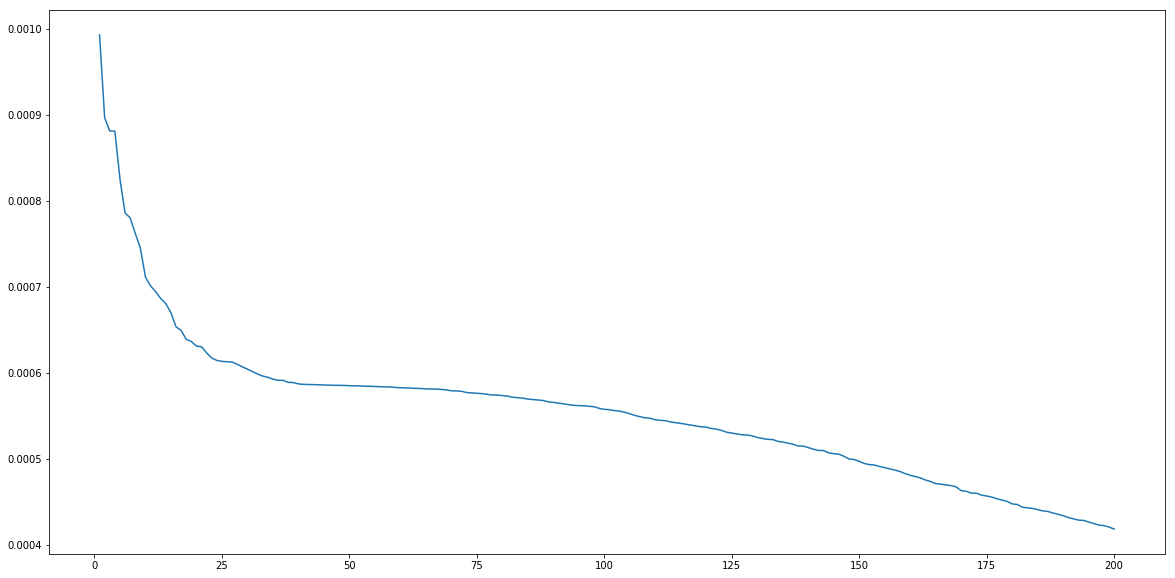

In [175]:
plt.figure(figsize=(20,10))
plt.plot(range(1,201,1),pca.explained_variance_ratio_)

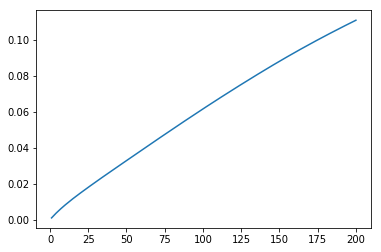

In [177]:
plt.plot(range(1,201,1),pca.explained_variance_ratio_.cumsum())

In [146]:
#pca8 = PCA(n_components=8)
#pca8.fit(x)
pca8.transform(x) 

array([[ 9.71554192e-07,  3.24756841e-06,  8.36429749e-06, ...,
         1.93312280e-05,  9.10381192e-04, -9.10381192e-04],
       [ 1.47266195e-05,  2.05259285e-05, -1.10729786e-05, ...,
        -7.01894330e-06, -1.86730543e-03,  1.86730543e-03],
       [ 3.39483431e-05, -4.67146769e-07,  2.82698780e-05, ...,
        -1.10720104e-05, -8.42105114e-04,  8.42105114e-04],
       ...,
       [ 8.34418376e-06,  6.72486310e-05, -1.81898444e-07, ...,
         4.64844683e-05,  1.39351332e-03, -1.39351332e-03],
       [ 3.30912905e-05,  1.43595158e-05,  6.04037126e-05, ...,
         3.38886340e-05, -2.93184017e-02,  2.93184017e-02],
       [-5.40390045e-06,  2.89571198e-06, -5.10108423e-05, ...,
         5.36481823e-06,  3.33675494e-02, -3.33675494e-02]])

In [178]:
transform_x=pca.transform(x)

In [219]:
x1=x.sample(200000,random_state=10)
from sklearn.cluster import KMeans

variance=[]
for i in range(5,20,1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x1)
    ini=kmeans.inertia_
    variance.append(ini)

    

MemoryError: 

In [220]:
variance

[]